# Forecast for synthetic seasonal time series data by moving average.
(Moving average with smooth past)
(Assignment from Coursera - Deep learning)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

/Users/jingyiliu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


1. Generating synthetic seasonal time series data.

In [3]:
def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 5 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def plot_series(time, series, format="-", title="", label=None, start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    if label:
        plt.legend()
    plt.grid(True)

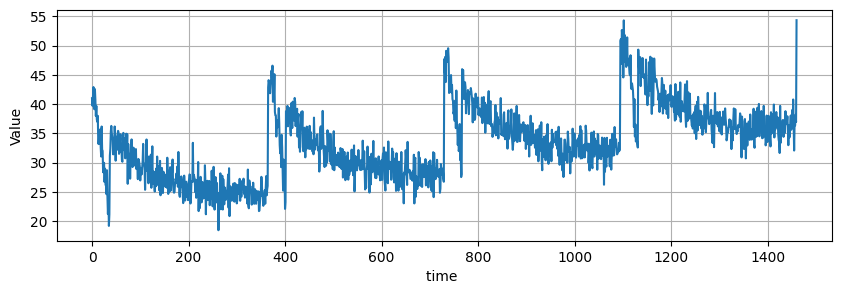

In [4]:
# The time dimension or the x-coordinate of the time series
TIME = np.arange(4 * 365 + 1, dtype="float32")

# Initial series is just a straight line with a y-intercept
y_intercept = 20
slope = 0.01
SERIES = trend(TIME, slope) + y_intercept

# Adding seasonality
amplitude = 20
SERIES += seasonality(TIME, period=365, amplitude=amplitude)

# Adding some noise
noise_level = 2
SERIES += noise(TIME, noise_level, seed=42)

# Plot the series
plt.figure(figsize=(10, 3))
plot_series(TIME, SERIES)
plt.xlabel('time ')
plt.show()

2. Split data into training data and validation data.

In [5]:
# Define time step to split the series
SPLIT_TIME = 1100

# GRADED FUNCTION: train_val_split
def train_val_split(time, series, time_step=SPLIT_TIME):

    ### START CODE HERE
    time_train = TIME[:time_step]
    series_train = SERIES[:time_step]
    time_valid = TIME[time_step:]
    series_valid = SERIES[time_step:]
    ### END CODE HERE

    return time_train, series_train, time_valid, series_valid

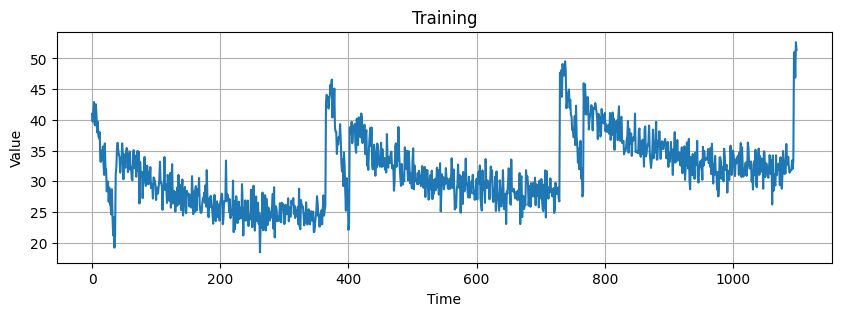

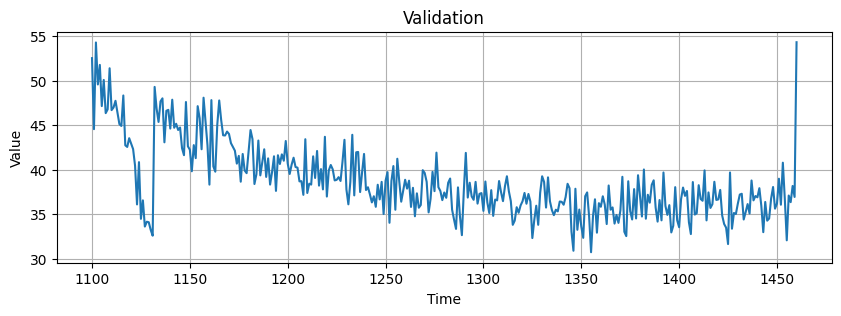

In [7]:
# Test your function
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

plt.figure(figsize=(10, 3))
plot_series(time_train, series_train, title="Training")
plt.show()

plt.figure(figsize=(10, 3))
plot_series(time_valid, series_valid, title="Validation")
plt.show()

3. Use `mse` and the `mae` for evaluation.

In [8]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

4. Forecasting by various methods.

4.(1). Moving average.

In [9]:
# This function receives a `series` and a `window_size` and computes the 
# moving average forecast for every point after the initial `window_size` values.
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values."""
    
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
        
    # Conver to a numpy array
    np_forecast = np.array(forecast)
    
    return np_forecast

mse: 12.88, mae: 2.36 for moving average forecast


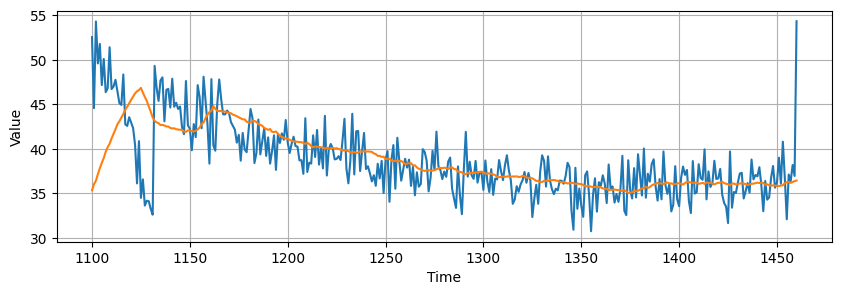

In [11]:
moving_avg = moving_average_forecast(SERIES, window_size=30)
# Slice it so it matches the validation period
moving_avg = moving_avg[1100 - 30:]

plt.figure(figsize=(10, 3))
plot_series(time_valid, series_valid)
plot_series(time_valid, moving_avg)

# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, moving_avg)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average forecast")


4.(2). Differencing.

moving average forecast with diff series has shape: (1046,)

moving average forecast with diff series after slicing has shape: (361,)

comparable with validation series: True


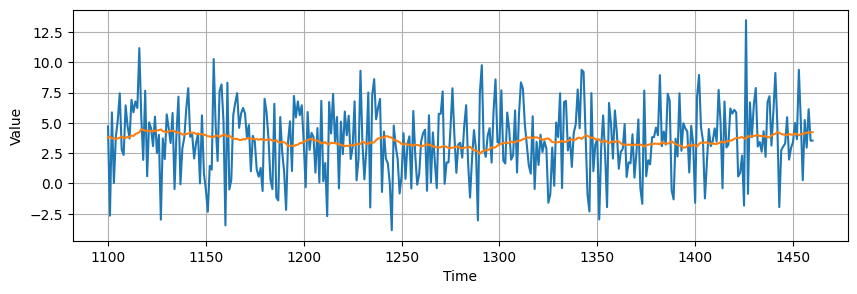

In [13]:
diff_series = (SERIES[365:]-SERIES[:-365])
diff_time = TIME[365:]

# Apply the moving avg to diff series
diff_moving_avg = moving_average_forecast(diff_series, 50)

print(f"moving average forecast with diff series has shape: {diff_moving_avg.shape}\n")

# Perform the correct slicing
diff_moving_avg = diff_moving_avg[SPLIT_TIME-365-50:]

print(f"moving average forecast with diff series after slicing has shape: {diff_moving_avg.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg.shape}")

plt.figure(figsize=(10, 3))
plot_series(time_valid, diff_series[1100 - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

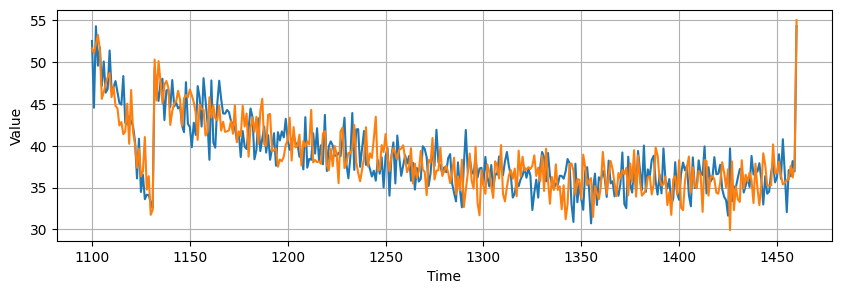

mse: 8.50, mae: 2.33 for moving average plus past forecast


In [15]:
# Slice the whole SERIES to get the past values
past_series = SERIES[SPLIT_TIME-365:-365]

# Add the past to the moving average of diff series
diff_moving_avg_plus_past = past_series + diff_moving_avg

plt.figure(figsize=(10, 3))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

mse, mae = compute_metrics(series_valid, diff_moving_avg_plus_past)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus past forecast")

(3). Use centered moving average with past values.

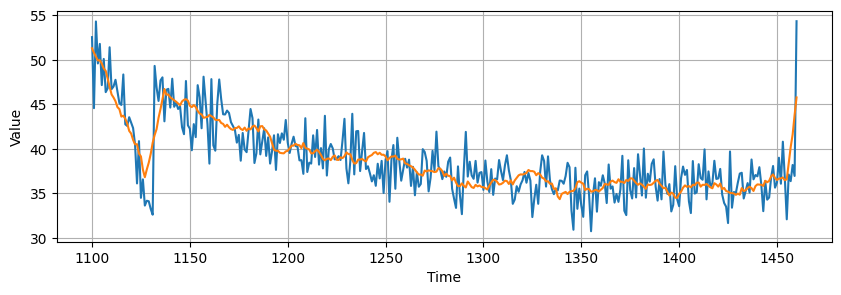

mse: 5.68, mae: 1.89 for moving average plus smooth past forecast


In [16]:
# Perform the correct split of SERIES
smooth_past_series = moving_average_forecast(SERIES[SPLIT_TIME-370:-360], 10)

# Add the smoothed out past values to the moving avg of diff series
diff_moving_avg_plus_smooth_past = smooth_past_series + diff_moving_avg

plt.figure(figsize=(10, 3))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, diff_moving_avg_plus_smooth_past)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus smooth past forecast")